In [56]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import FunctionTransformer
import math

In [28]:
# Load the dataset
df = pd.read_csv("/content/CarPrice_Assignment.csv")

In [29]:
# Display the first few rows of the dataset
print(df.head())

   car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \

In [30]:
# Display dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [52]:


class DataCleaningAndVisualization:
    def data_info(self, data):
        cols = data.columns
        unique_val = [data[col].value_counts().head(10).index.to_numpy() for col in cols]
        n_uniques = [data[col].nunique() for col in cols]
        dtypes = [data[col].dtype for col in cols]
        nulss = [data[col].isnull().sum() for col in cols]
        dup = [data.duplicated().sum() for col in cols]
        return pd.DataFrame({'Col': cols, 'dtype': dtypes, 'n_uniques': n_uniques, 'n_nan': nulss, 'unique_val': unique_val, 'duplicated': dup})

    def categorical_plot(self, data, columns, numbers_of_cat_value):
        total_cols = 3
        total_rows = math.ceil(len(columns) / total_cols)
        plt.figure(figsize=(20, 5 * total_rows))
        plot_idx = 1
        for column in columns:
            if (data[column].nunique()) <= numbers_of_cat_value:
                ax = plt.subplot(total_rows, total_cols, plot_idx)
                sns.countplot(x=data[column], palette="rocket", hue=data[column])
                ax.set_title(f"Count Plot of {column}")
                plot_idx += 1
            else:
                print(f"Column '{column}' is not categorical.")
        plt.tight_layout()
        plt.show()

    def continuous_plot(self, data, columns, numbers_of_cat_value):
        total_cols = 3
        total_rows = math.ceil(len(columns) / total_cols)
        plt.figure(figsize=(20, 5 * total_rows))
        plot_idx = 1
        for column in columns:
            if (data[column].nunique()) >= numbers_of_cat_value and (data[column].dtype != 'object') and (data[column].value_counts().iloc[0]>=numbers_of_cat_value):
                ax = plt.subplot(total_rows, total_cols, plot_idx)
                sns.histplot(data[column])
                ax.set_title(f"histograme plot of {column}")
                plot_idx += 1
            else:
                print(f"Column '{column}' is not countinuous.")
        plt.tight_layout()
        plt.show()

    def boxplot_numeric_columns(self, data):
        numeric_columns = data.select_dtypes(include=['number'])
        num_cols = len(numeric_columns.columns)
        plt.figure(figsize=(25, 5))
        for i, column in enumerate(numeric_columns.columns):
            plt.subplot(1, num_cols, i+1)
            sns.boxplot(x=numeric_columns[column])
            plt.title(f'Box plot for {column}')

    def drop_duplicat(self, data, columns_uniques):
        index=data[data.drop(columns_uniques,axis=1).duplicated()].index
        print("Number of duplicated rows is",len(index))
        return data.drop(index,axis=0)

    def remove_outliers_iqr_countinuous(self, data, columns):
        data_copy = data.copy()
        for col in columns:
            if data_copy[col].dtype != 'object':
                q1, q3 = data_copy[col].quantile([0.25, 0.75])
                iqr = q3 - q1
                lower_whisker, upper_whisker = q1 - 1.5 * iqr, q3 + 1.5 * iqr
                filt = (data_copy[col] < lower_whisker) | (data_copy[col] > upper_whisker)
                data_copy = data_copy[~filt]
        return data_copy.reset_index(drop=True)

    def remove_outliers_z_score_countinuous(self, data, upper_threshold=3, lower_threshold=-3):
        data_copy = data.copy()
        feature = data_copy.select_dtypes(np.number).columns
        skewness = data_copy[feature].skew()
        for column in feature:
            if -0.5 <= skewness[column] <= 0.5:
                z_scores = (data_copy[column] - data_copy[column].mean()) / data_copy[column].std()
                outliers = (z_scores < lower_threshold) | (z_scores > upper_threshold)
                data_copy = data_copy[~outliers]
        return data_copy.reset_index(drop=True)

    def Skewness_log_square(self, data, numbers_of_cat_value):
        features = data.select_dtypes(np.number).columns
        for feature in features:
            if data[feature].nunique() <= numbers_of_cat_value:  # Check if unique values are greater than 10
                print(f" Categorical Features {feature} ")
                continue

            skewness = data[feature].skew()
            if skewness > 0.5:
                transformation = np.log1p
                transformation_name = "Log"
            elif skewness < -0.5:
                transformation = np.square
                transformation_name = "Square"
            else:
                print(f"Normal distribution {feature}")
                continue

            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.title(f"Distribution of {feature} before Transformation", fontsize=15)
            sns.histplot(data[feature], kde=True, color="red")
            plt.subplot(1, 2, 2)

            df_transformed = transformation(data[feature])
            plt.title(f"Distribution of {feature} after Transformation", fontsize=15)
            sns.histplot(df_transformed, bins=20, kde=True, legend=False)
            plt.xlabel(feature)
            plt.show()

            print(f"Skewness was {round(data[feature].skew(), 5)} before & is {round(pd.Series(df_transformed).skew(), 5)} after {transformation_name} transformation.")
            data[feature] = df_transformed
        return data

    def remove_categorical_outliers(self, data, columns, threshold):
        for col in columns:
            series = data[col].value_counts()
            outliers = series[series < threshold].index
            data = data[~data[col].isin(outliers)]
            print(col, np.array(outliers))
        return data.reset_index(drop=True)

                 Col    dtype  n_uniques  n_nan  \
0             car_ID    int64        205      0   
1          symboling    int64          6      0   
2            CarName   object        147      0   
3           fueltype   object          2      0   
4         aspiration   object          2      0   
5         doornumber   object          2      0   
6            carbody   object          5      0   
7         drivewheel   object          3      0   
8     enginelocation   object          2      0   
9          wheelbase  float64         53      0   
10         carlength  float64         75      0   
11          carwidth  float64         44      0   
12         carheight  float64         49      0   
13        curbweight    int64        171      0   
14        enginetype   object          7      0   
15    cylindernumber   object          7      0   
16        enginesize    int64         44      0   
17        fuelsystem   object          8      0   
18         boreratio  float64  

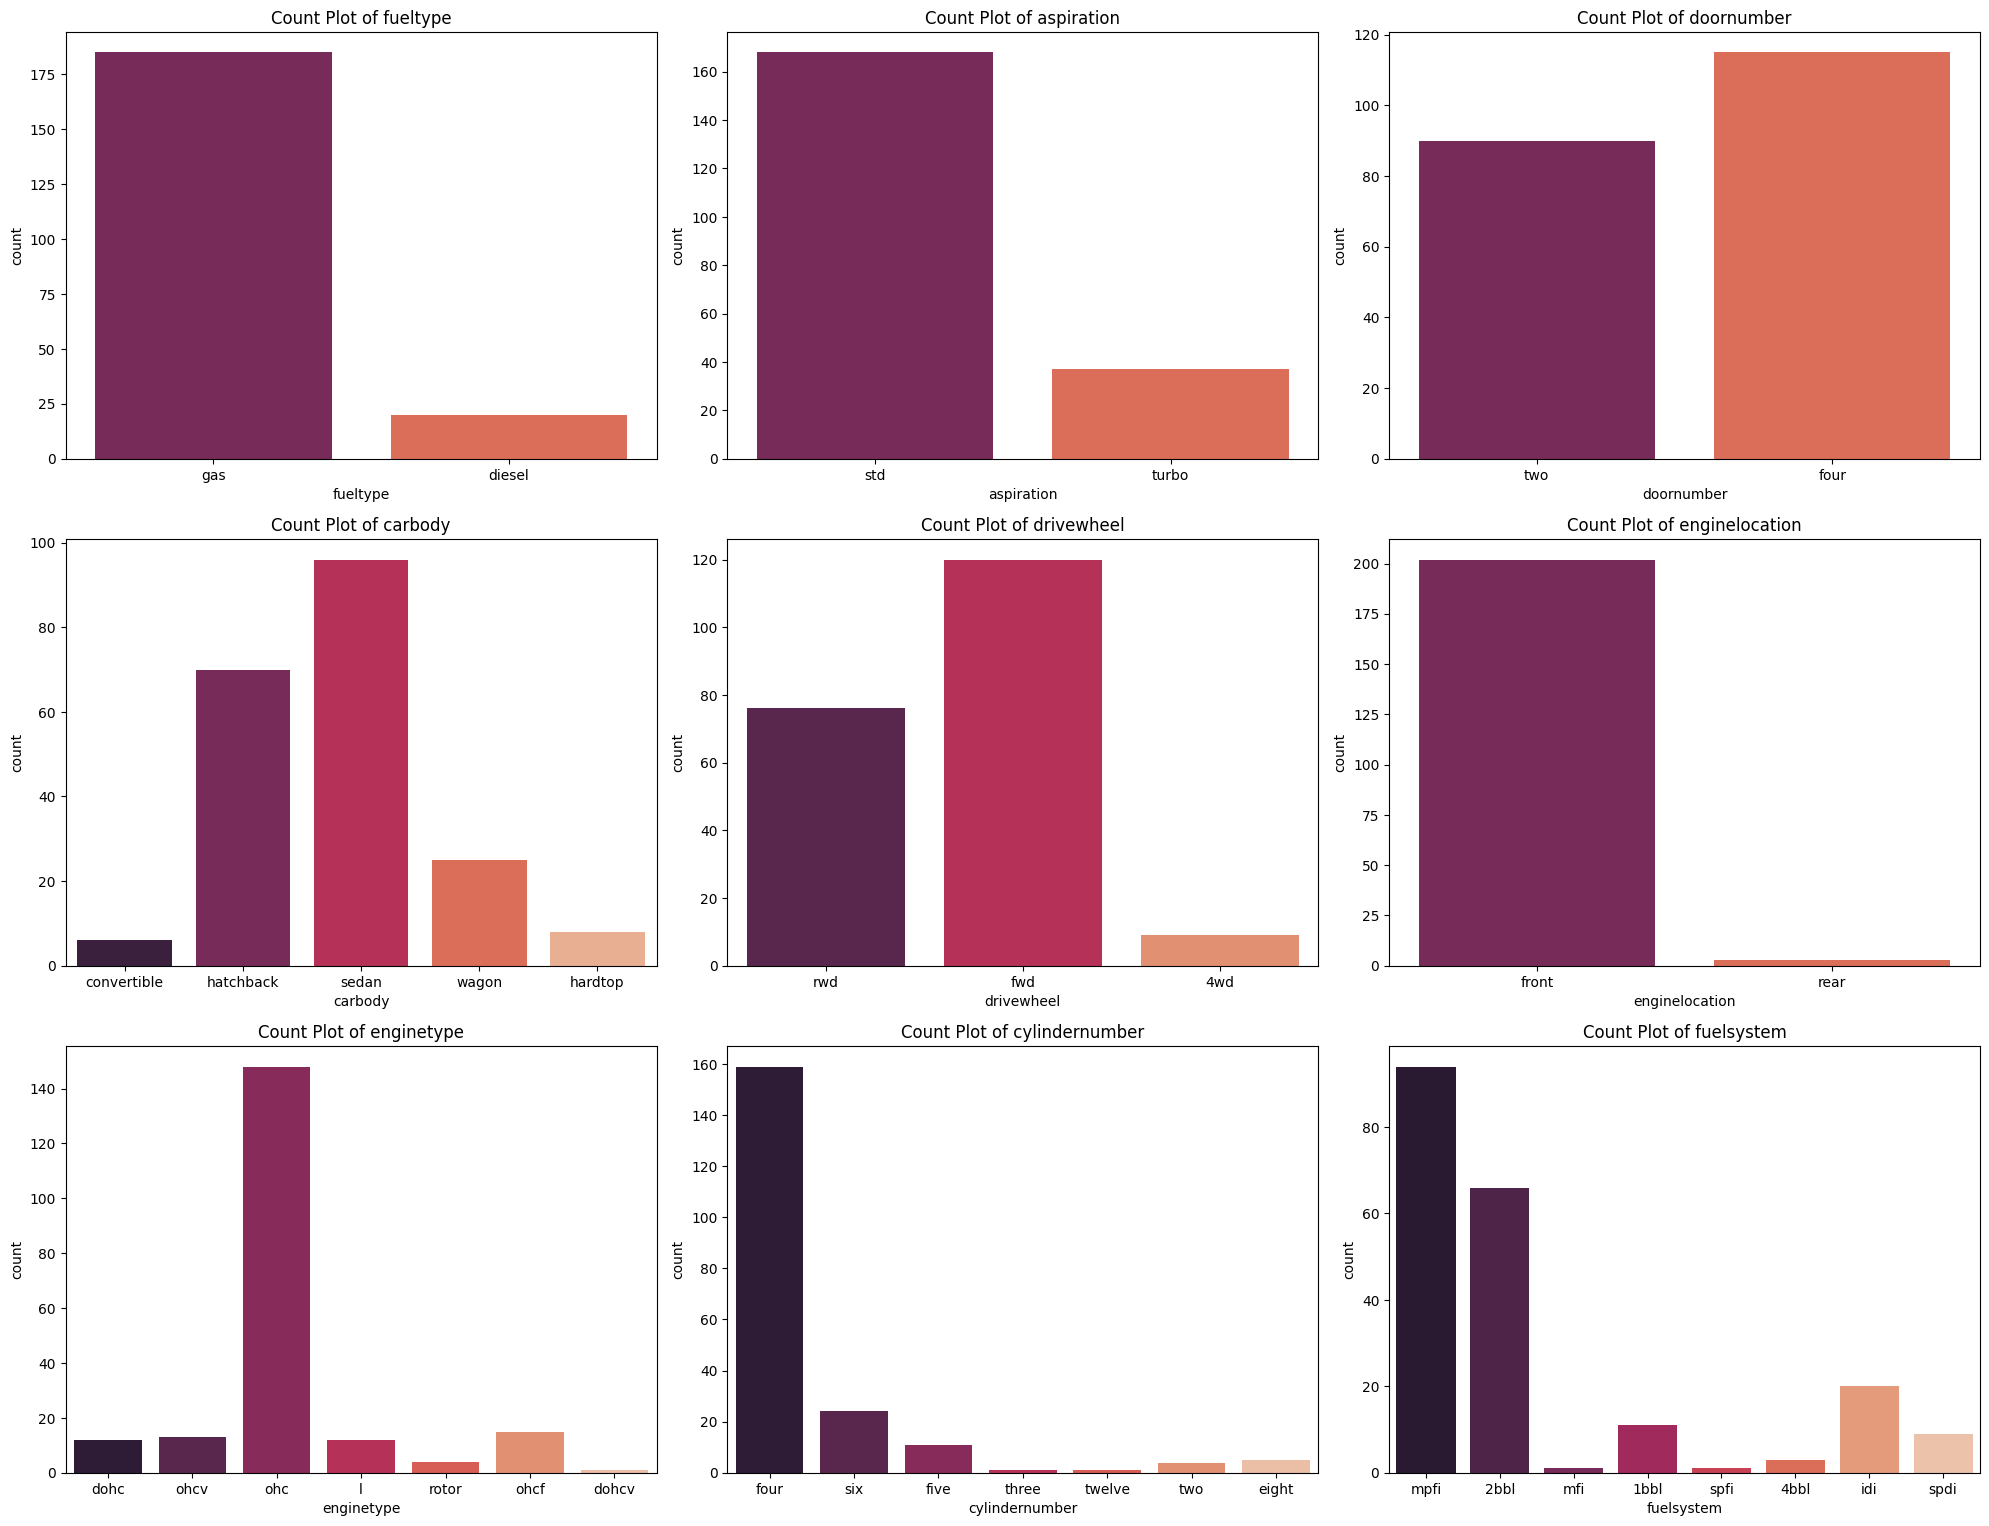

Column 'car_ID' is not countinuous.
Column 'symboling' is not countinuous.
Column 'curbweight' is not countinuous.
Column 'price' is not countinuous.


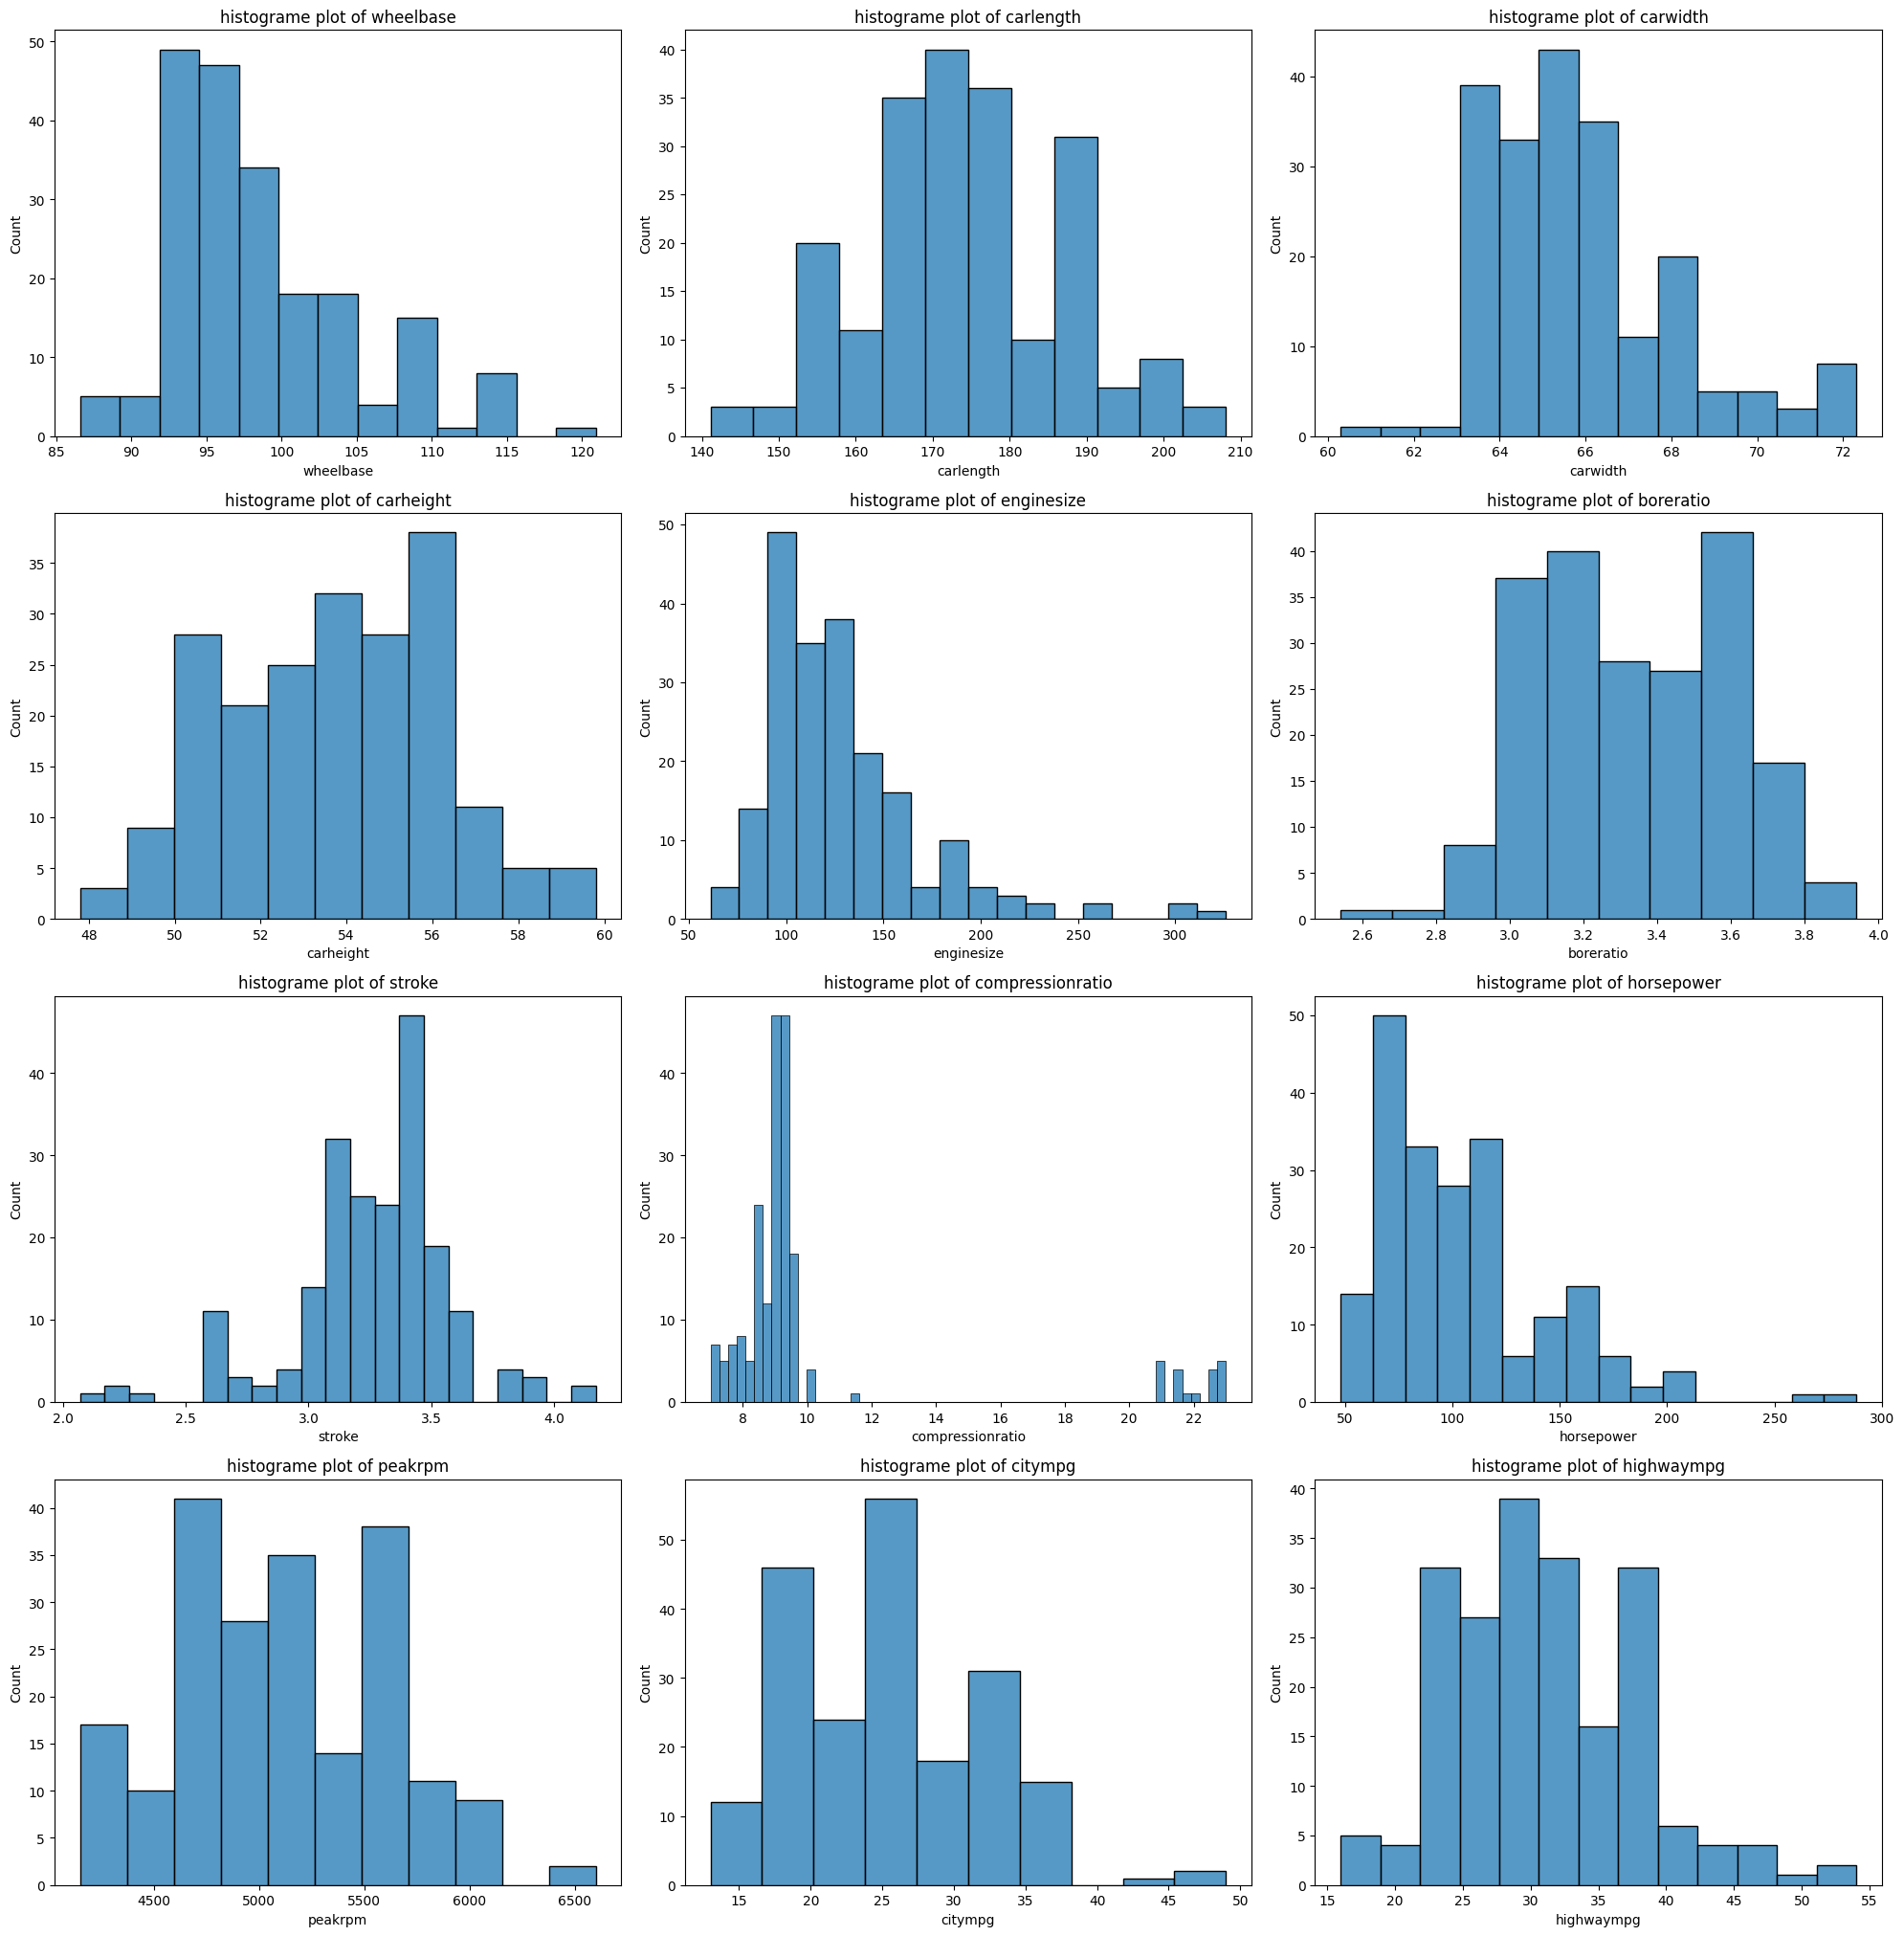

In [58]:
df = pd.read_csv("/content/CarPrice_Assignment.csv")


data_cleaning_vis = DataCleaningAndVisualization()


data_info_df = data_cleaning_vis.data_info(df)
print(data_info_df)

data_cleaning_vis.categorical_plot(df, df.select_dtypes(include=object).columns, 10)
data_cleaning_vis.continuous_plot(df, df.select_dtypes(include=np.number).columns, 10)

In [31]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [32]:
# Handle missing values by imputing with the mean
df.fillna(df.mean(), inplace=True)

<ipython-input-32-4a3ee39a9866>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


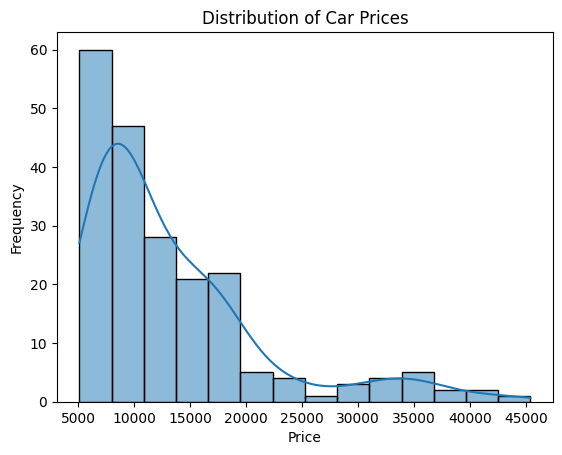

In [33]:
# Explore the distribution of the target variable (car prices)
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

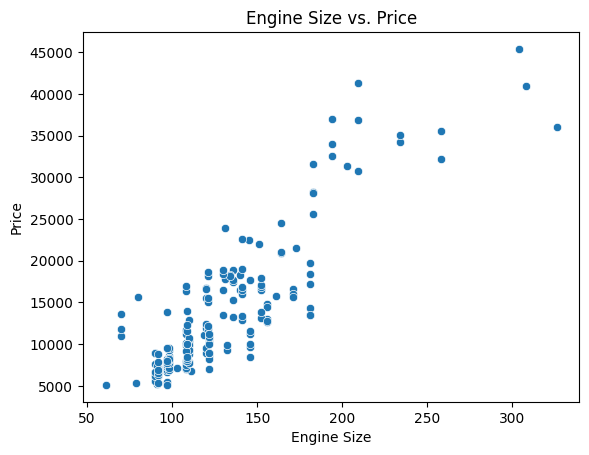

In [34]:
# Explore the relationship between independent variables and the target variable
sns.scatterplot(x='enginesize', y='price', data=df)
plt.title('Engine Size vs. Price')
plt.xlabel('Engine Size')
plt.ylabel('Price')
plt.show()

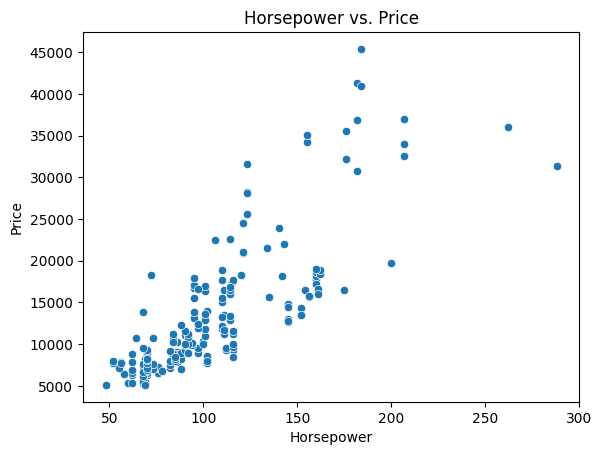

In [35]:
sns.scatterplot(x='horsepower', y='price', data=df)
plt.title('Horsepower vs. Price')
plt.xlabel('Horsepower')
plt.ylabel('Price')
plt.show()

In [36]:
# Analyze the relationship between independent variables and the target variable using correlation matrix
correlation_matrix = df.corr()

<ipython-input-36-a9e462f098dc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [37]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

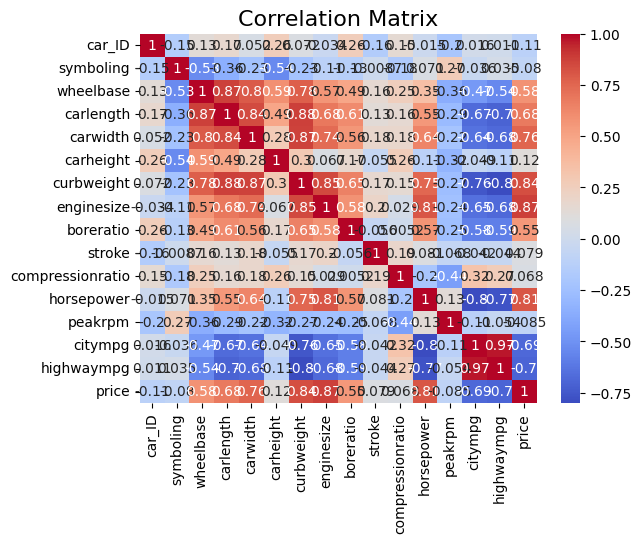

In [38]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [39]:
# Preprocessing

# Handle categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['symboling', 'fueltype', 'aspiration', 'doornumber',
                                 'carbody', 'drivewheel', 'enginelocation', 'enginetype',
                                 'fuelsystem'])

In [40]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize',
                      'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
                      'highwaympg', 'price']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [41]:
# Split the dataset into training and testing sets
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Display the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (164, 53)
Shape of X_test: (41, 53)
Shape of y_train: (164,)
Shape of y_test: (41,)


In [43]:
# Feature engineering

# Convert non-numeric columns to numeric data types
df['enginesize'] = pd.to_numeric(df['enginesize'], errors='coerce')
df['cylindernumber'] = pd.to_numeric(df['cylindernumber'], errors='coerce')
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

In [44]:
# Handle outliers using z-score
non_numeric_columns = ['car_ID', 'CarName']
df.drop(non_numeric_columns, axis=1, inplace=True)
z_score = np.abs(stats.zscore(df))
df = df[(z_score < 3).all(axis=1)]

In [45]:
# Dimensionality reduction using PCA
X_pca = X.drop(columns=['CarName'])
pca = PCA(n_components=0.95)

X_encoded = pd.get_dummies(X_pca)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_encoded)

In [46]:
# Analyze the relationship between independent variables and the target variable using correlation matrix
correlation_matrix = df.corr()

In [47]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


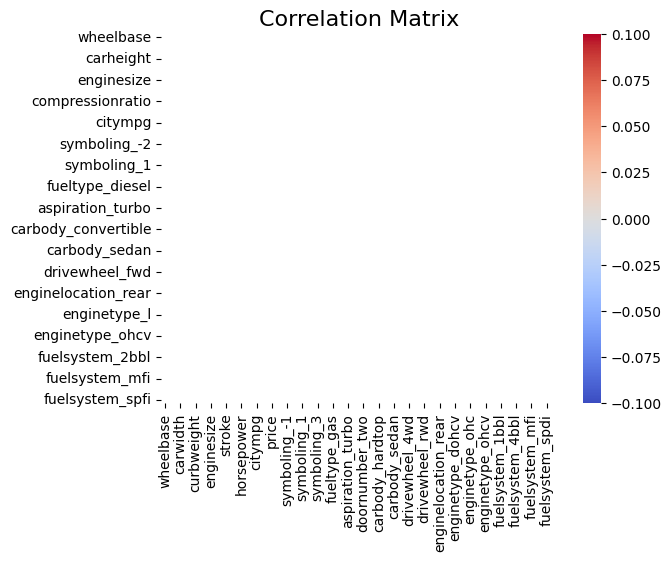

In [48]:
# Adjust the color palette, annotation text size, and add a title
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [49]:
# Split the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=11)

In [50]:
# Display the shapes of the reduced training and testing sets
print(f"Shape of X_train_reduced: {X_train_reduced.shape}")
print(f"Shape of X_test_reduced: {X_test_reduced.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_reduced: (164, 1)
Shape of X_test_reduced: (41, 1)
Shape of y_train: (164,)
Shape of y_test: (41,)
